In [1]:
# Clustering Models
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from collections import Counter
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier

# Preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures

# model_selection
from sklearn.model_selection import (train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, 
learning_curve, cross_val_predict, cross_validate, permutation_test_score, validation_curve, RandomizedSearchCV)

# Metrics
from sklearn.metrics import (accuracy_score, cohen_kappa_score, confusion_matrix, mean_squared_error, r2_score,
root_mean_squared_error, recall_score, roc_auc_score, roc_curve, mean_absolute_error, auc, classification_report, 
f1_score, silhouette_score, adjusted_rand_score)

# Display all columns
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
clm = ['Sex', # nominal M, F, and I (infant)
	   'Length', # continuous	mm	Longest shell measurement
	   'Diameter', # continuous	mm	perpendicular to length
	   'Height', # continuous	mm	with meat in shell
	   'Whole weight', # continuous	grams	whole abalone
	   'Shucked weight', # continuous	grams	weight of meat
	   'Viscera weight', # continuous	grams	gut weight (after bleeding)
	   'Shell weight', # continuous	grams	after being dried
	   'Rings' # integer			+1.5 gives the age in years 
      ]

In [3]:
df = pd.read_csv('abalone.csv', engine='pyarrow', names=clm)
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
# Lowering columns
df.columns = df.columns.str.lower() 

In [5]:
# Rename columns
df.rename(columns={'whole weight':'whole_weight', 'shucked weight':'shucked_weight', 
                  'viscera weight':'viscera_weight', 'shell weight':'shell_weight'},  inplace=True) 


In [6]:
# Data Integrity Check
print("Big Query Statistics:")
print('-' * 127)
print(f"🚣‍♀️ DataFrame Shape: {df.shape}")
print('-' * 127)
print(f"Columns to list:\n{df.columns.tolist()}")
print('-' * 127)
print(f"📊 DataFrame Info: {df.info(memory_usage='deep')}")
print('-' * 127)
print(f"📈 DataFrame Distribution:\n {df.describe()}")
print('-' * 127)

missing_values = df.isna().sum()
#today_date = datetime.date.today() #+ datetime.timedelta(days=2) # test function works
#date_count = pd.DataFrame(jobs_all.date_time.dt.date.value_counts())
#missing_dates = list(pd.date_range(start=first_date, end=today_date).difference(date_count.index))
if len(missing_values) < 0:
    print("❌ Missing data for following columns:")
else:
    print(f"✅ No missing values for df:\n{missing_values}")

Big Query Statistics:
-------------------------------------------------------------------------------------------------------------------------------
🚣‍♀️ DataFrame Shape: (4177, 9)
-------------------------------------------------------------------------------------------------------------------------------
Columns to list:
['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
-------------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   sh

In [7]:
# Value_counts - Unique
objects = df.select_dtypes(include=['object','category'])
for col in objects.columns:
    #print(f"\n{col}:")
    print(f"{'-'*127}")
    print(df[col].value_counts())

-------------------------------------------------------------------------------------------------------------------------------
sex
M    1528
I    1342
F    1307
Name: count, dtype: int64


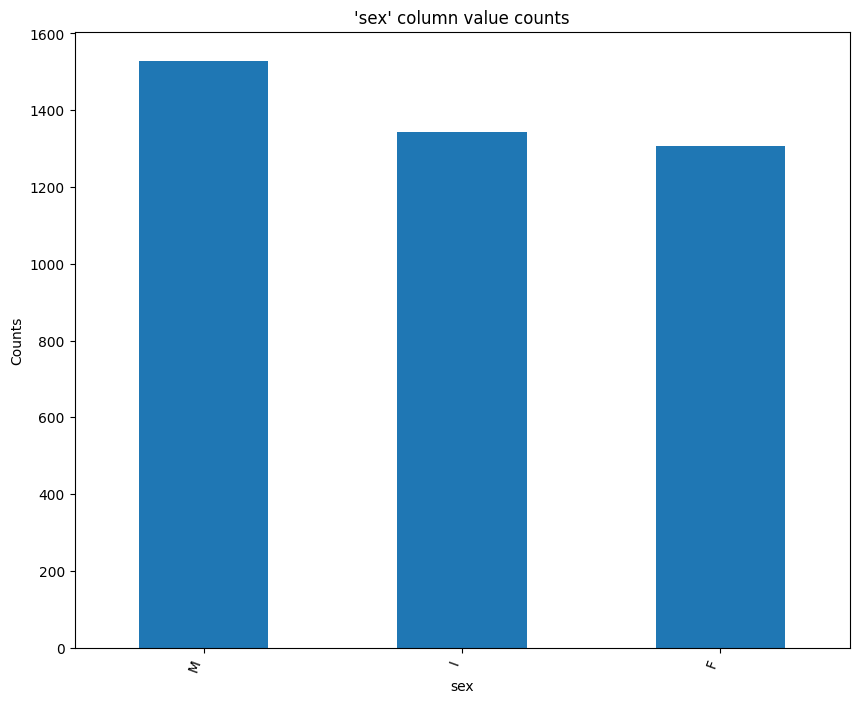

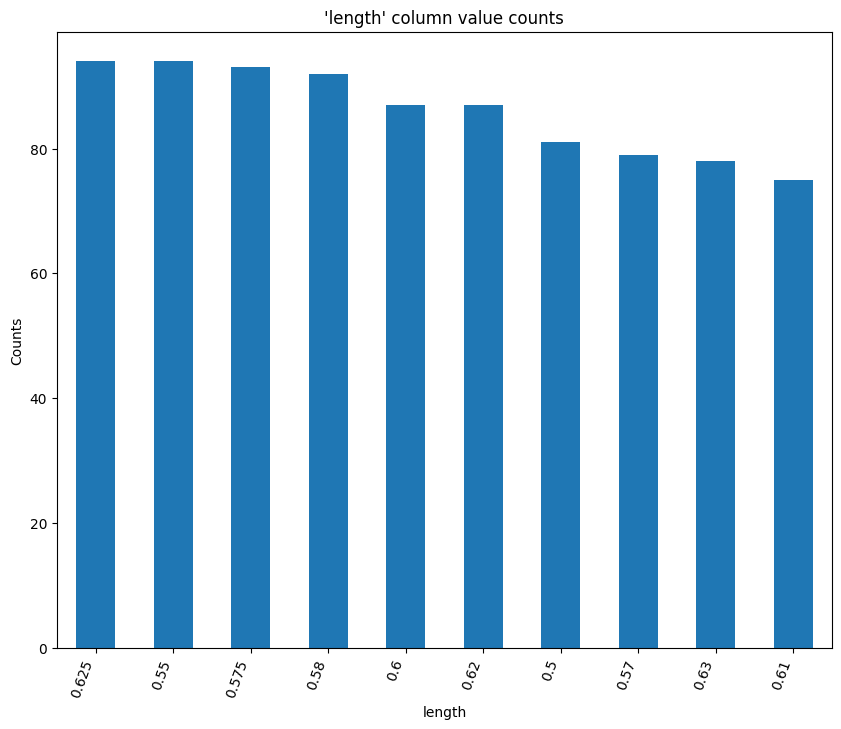

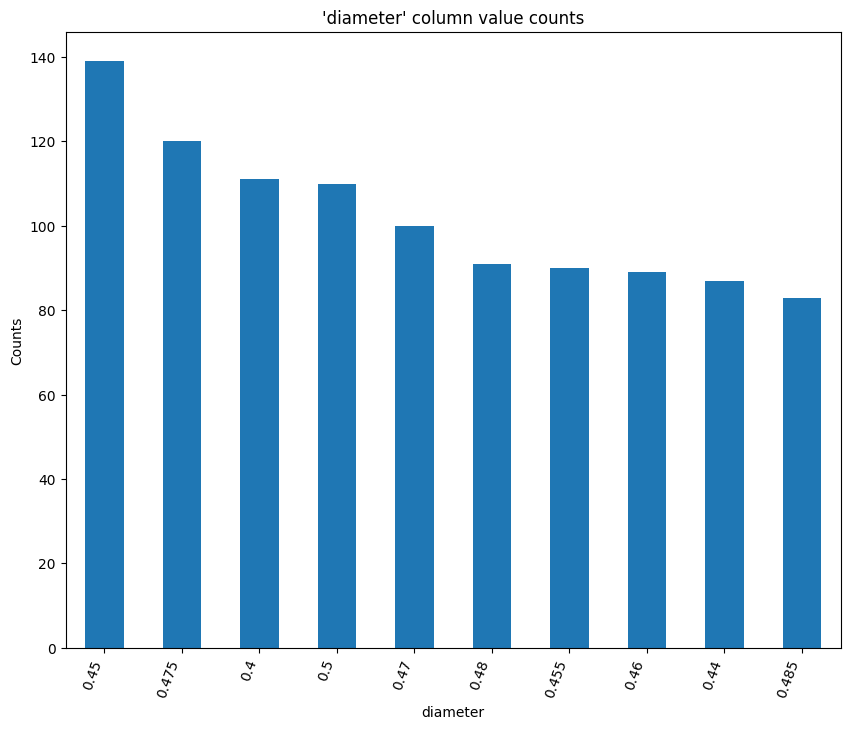

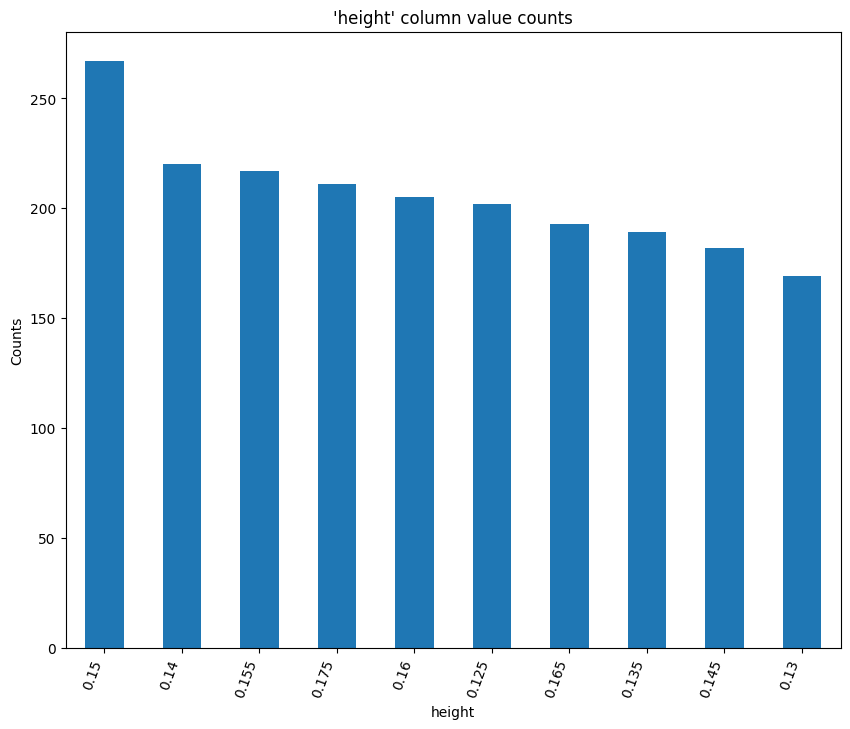

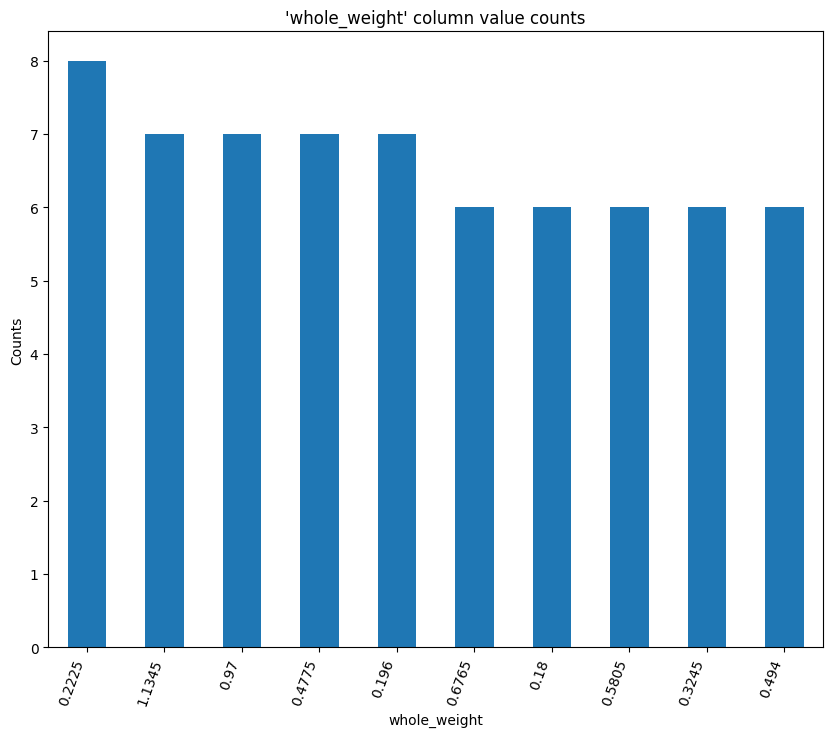

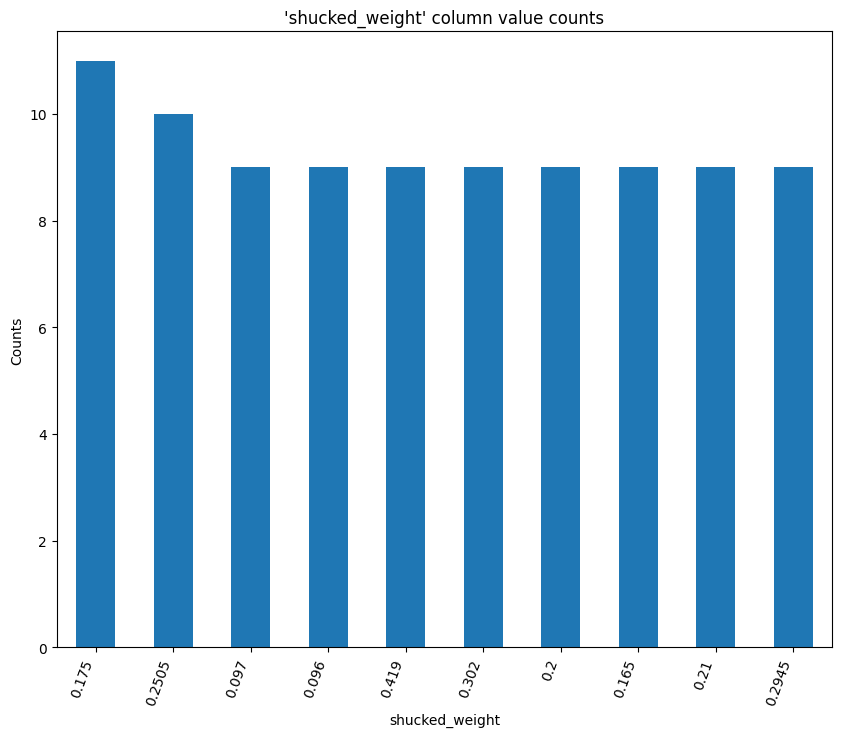

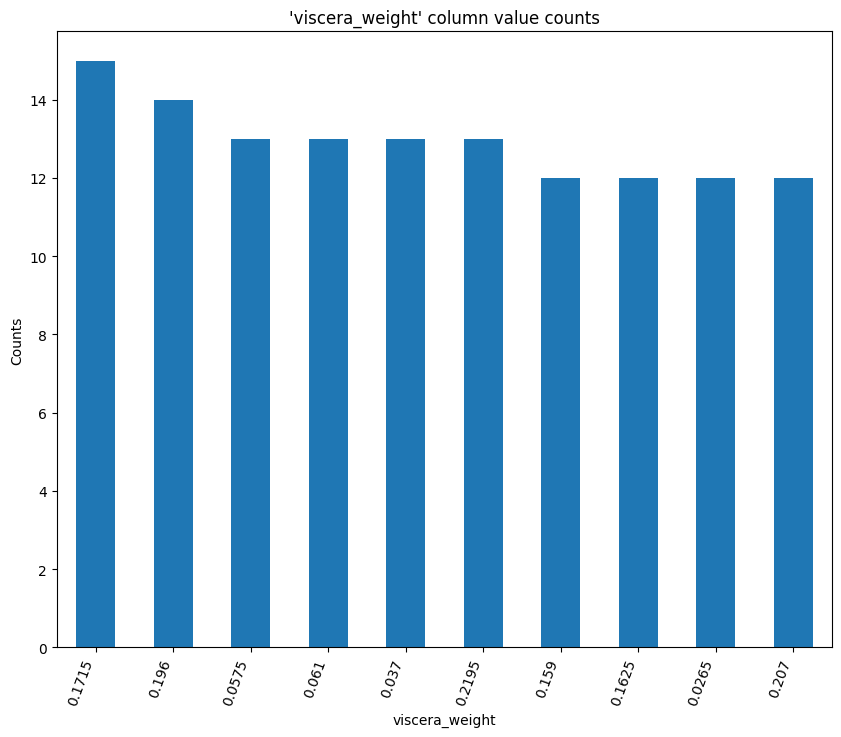

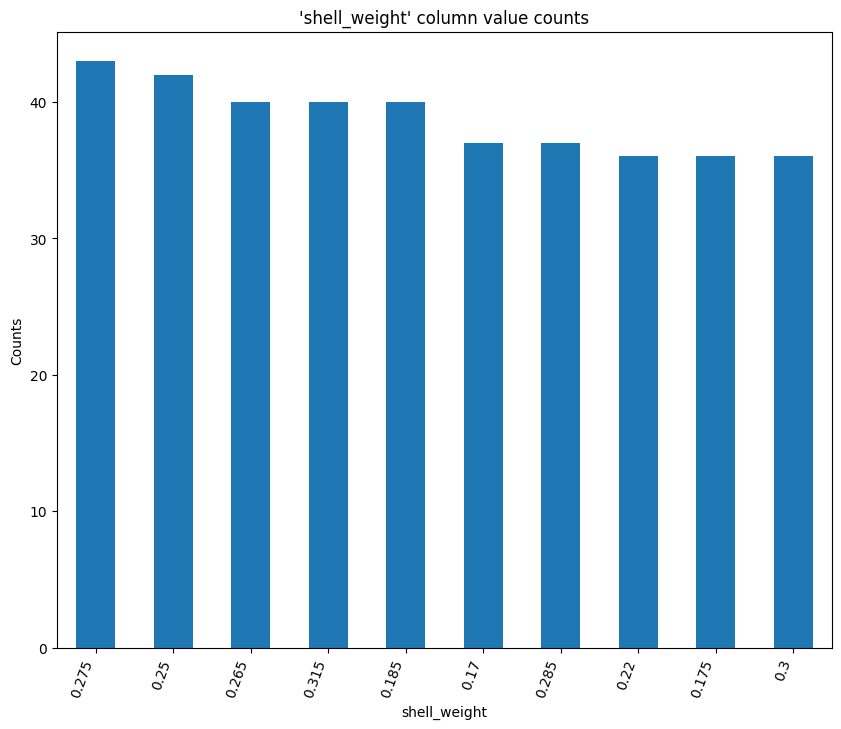

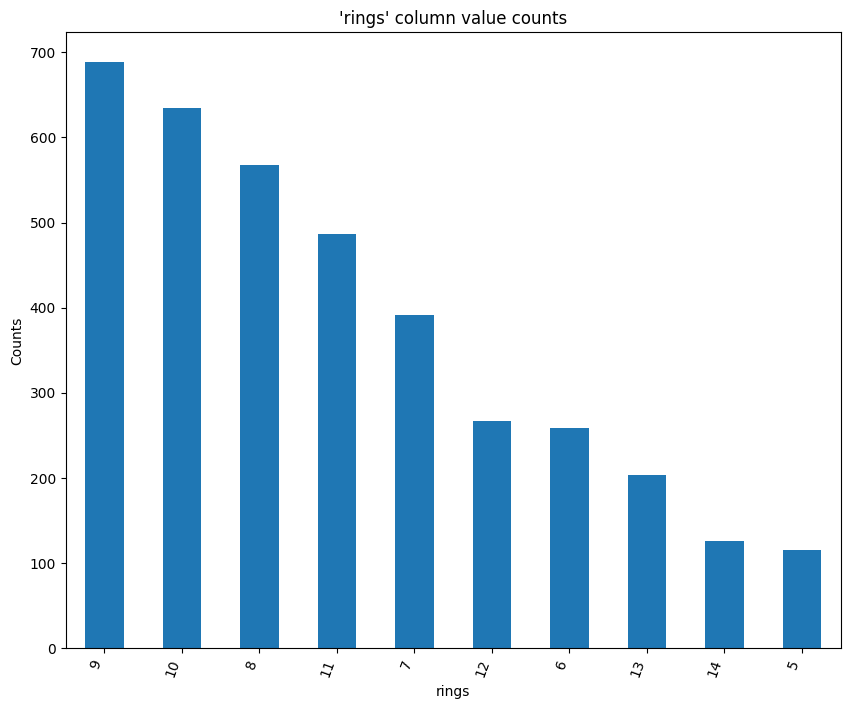

In [8]:
# Data Distribution
# Exploratory Data Analysis
def eda_plot(column, topn=10):
    plt.figure(figsize=(10, 8))
    df[column].value_counts().nlargest(topn).plot(kind='bar')
    plt.title(f"'{column}' column value counts")
    plt.ylabel("Counts")
    plt.xticks(rotation = 70, ha='right')
    plt.show()

columns = df.columns

for column in columns:
    eda_plot(column)

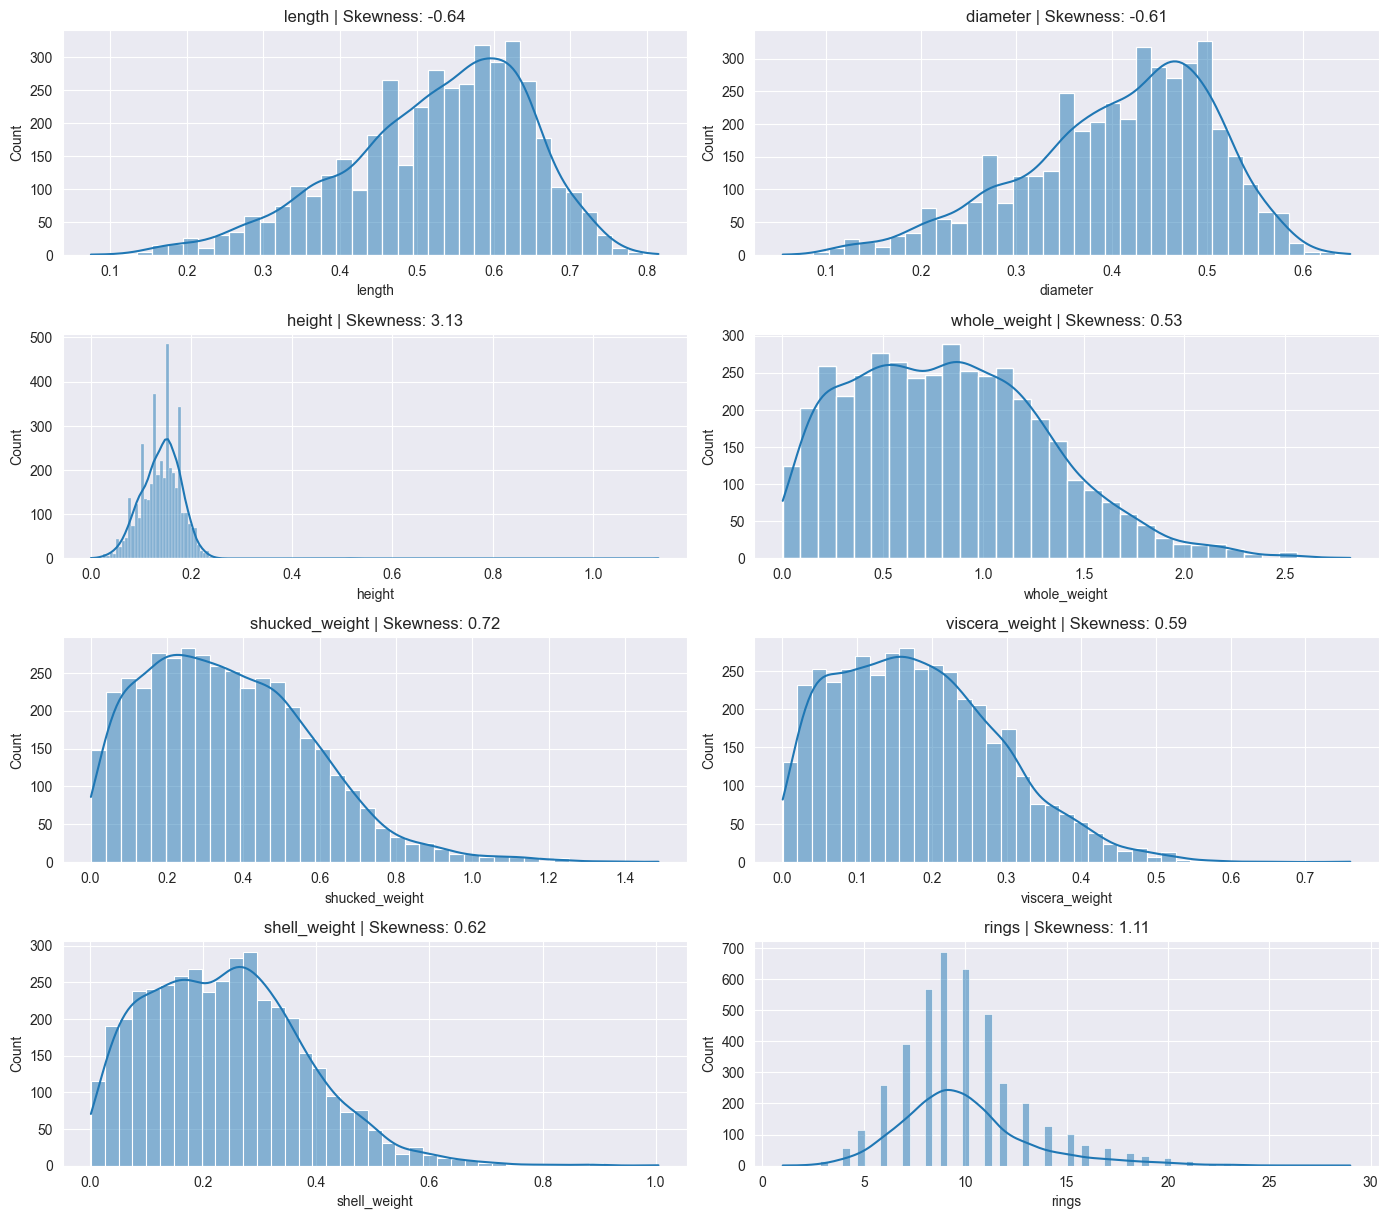

In [9]:
# Kernel Density Plot for understanding variance in the dataset
sns.set_style("darkgrid")
numerical_columns = df.select_dtypes(include=["int", "float"]).columns 
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

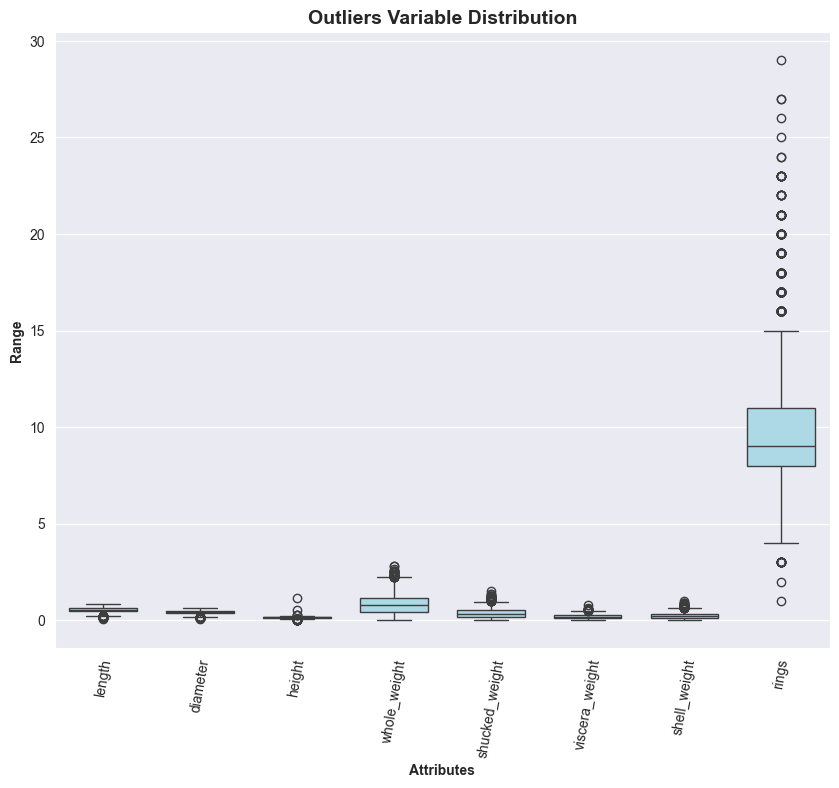

In [10]:
# Visualize Outlier Analysis of many columns at once
num_cols = df.select_dtypes(include=['int', 'float']).columns

# Option 2: Use color parameter instead of palette
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data=df[num_cols], orient="v", 
           color="lightblue", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize=14, fontweight='bold')
plt.ylabel("Range", fontweight='bold')
plt.xlabel("Attributes", fontweight='bold')
plt.xticks(rotation=80);

In [15]:
df.columns

Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings'], dtype='object')

In [50]:
# Removing (statistical) outliers for any column
Q1 = df['shell_weight'].quantile(0.25)
Q3 = df['shell_weight'].quantile(0.75)
IQR = Q3 - Q1
print(f"Shape {df.shape} with Outliers")
df = df[(df['shell_weight'] >= Q1 - 1.5 * IQR) & (df['shell_weight'] <= Q3 + 1.5 * IQR)]
print(f"Shape {df.shape} without Outliers")  

Shape (3762, 9) with Outliers
Shape (3762, 9) without Outliers


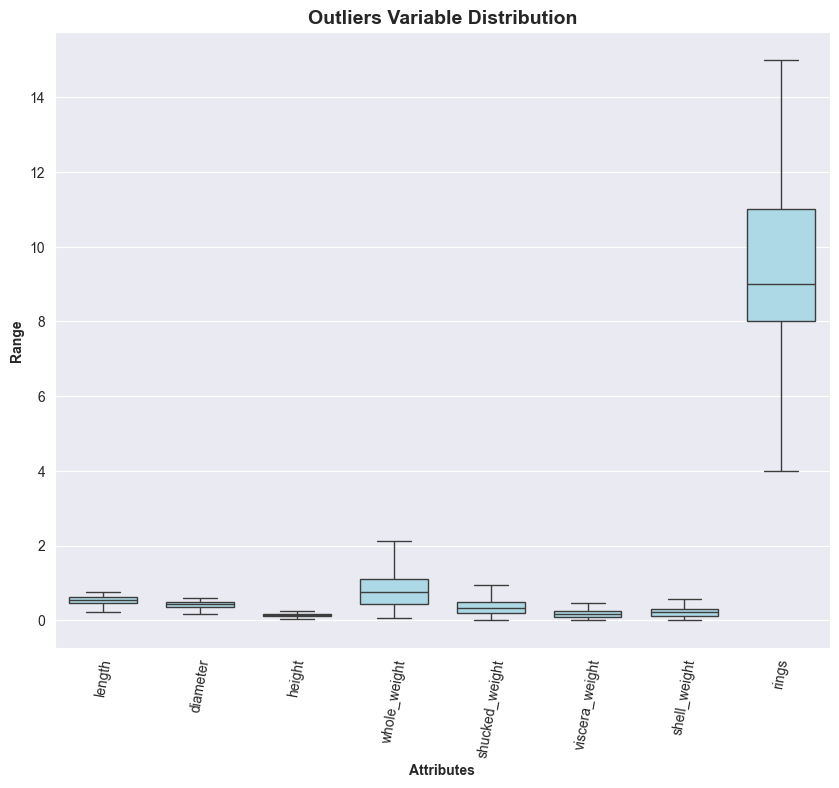

In [51]:
# Visualize Outlier Analysis of many columns at once
num_cols = df.select_dtypes(include=['int', 'float']).columns

# Option 2: Use color parameter instead of palette
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data=df[num_cols], orient="v", 
           color="lightblue", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize=14, fontweight='bold')
plt.ylabel("Range", fontweight='bold')
plt.xlabel("Attributes", fontweight='bold')
plt.xticks(rotation=80);

In [59]:
df.to_csv('clean_abalone.csv', index=False)

In [62]:
# Option 2: Use a loop for multiple columns
categorical_cols = df.select_dtypes(include=['object', 'category'])
label_encoders = {} 

for col in categorical_cols: 
    le = LabelEncoder() 
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for potential inverse transform

1. ELBOW METHOD ANALYSIS


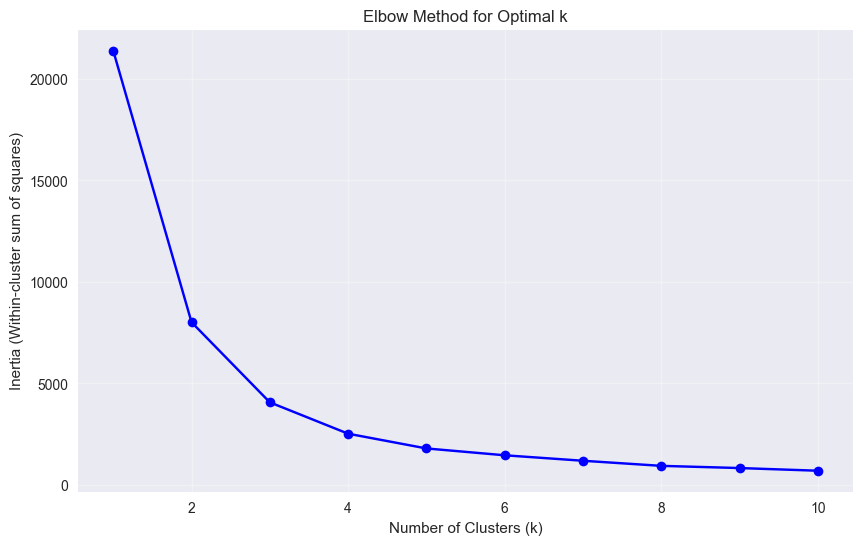

-------------------------------------------------------------------------------------------------------------------------------


In [69]:
X = df.drop(columns=['sex','sex_encoded'], axis=1)

# Set style for better plots
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Example 1: Finding Optimal K using Elbow Method
def elbow_method(X, max_k=10):
    """Find optimal k using elbow method"""
    inertias = []
    k_range = range(1, max_k + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Within-cluster sum of squares)')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return k_range, inertias

# Example 1: Elbow Method
print("1. ELBOW METHOD ANALYSIS")
k_range, inertias = elbow_method(X, max_k=10)
print("-" * 127)

2. SILHOUETTE ANALYSIS
k=2: Silhouette Score = 0.529
k=3: Silhouette Score = 0.529
k=4: Silhouette Score = 0.516
k=5: Silhouette Score = 0.508
k=6: Silhouette Score = 0.488
k=7: Silhouette Score = 0.508
k=8: Silhouette Score = 0.549


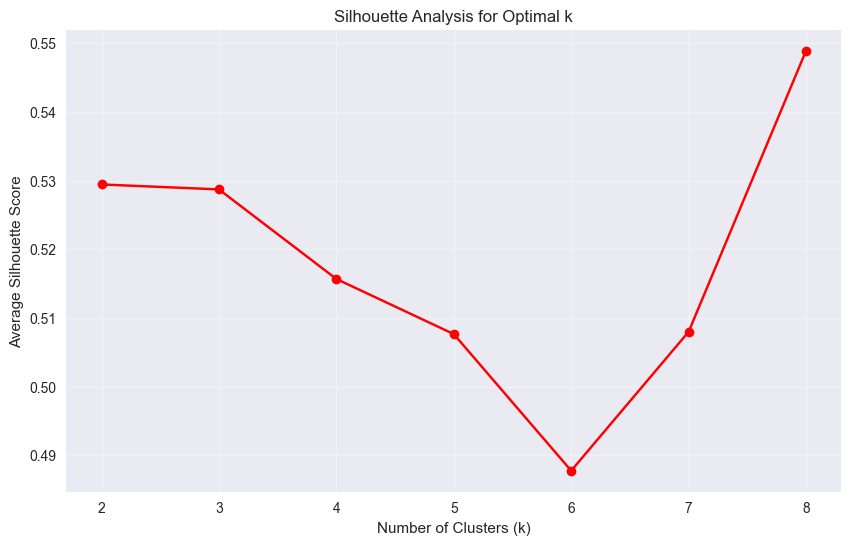

Optimal k based on silhouette score: 8
-------------------------------------------------------------------------------------------------------------------------------


In [70]:
# Example 2: Silhouette Analysis
def silhouette_analysis(X, max_k=10):
    """Analyze silhouette scores for different k values"""
    silhouette_scores = []
    k_range = range(2, max_k + 1)  # Start from 2 (need at least 2 clusters)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f'k={k}: Silhouette Score = {silhouette_avg:.3f}')
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, 'ro-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('Silhouette Analysis for Optimal k')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Find optimal k
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f'Optimal k based on silhouette score: {optimal_k}')
    
    return k_range, silhouette_scores, optimal_k

# Example 2: Silhouette Analysis
print("2. SILHOUETTE ANALYSIS")
k_range_sil, sil_scores, optimal_k = silhouette_analysis(X, max_k=8)
print("-" * 127)    

In [77]:
# Example 3: Comprehensive Parameter Tuning
def comprehensive_tuning(X, true_labels=None):
    """Comprehensive parameter tuning for K-means"""
    
    # Parameters to tune
    n_clusters_range = range(2, 11)
    init_methods = ['k-means++', 'random']
    n_init_values = [10, 20, 50]
    max_iter_values = [100, 300, 500]
    
    best_params = {}
    best_score = -1
    results = []
    
    print("Tuning K-means parameters...")
    print("-" * 127)
    
    for n_clusters in n_clusters_range:
        for init_method in init_methods:
            for n_init in n_init_values:
                for max_iter in max_iter_values:
                    # Fit K-means with current parameters
                    kmeans = KMeans(
                        n_clusters=n_clusters,
                        init=init_method,
                        n_init=n_init,
                        max_iter=max_iter,
                        random_state=42
                    )
                    
                    labels = kmeans.fit_predict(X)
                    
                    # Calculate metrics
                    silhouette = silhouette_score(X, labels)
                    inertia = kmeans.inertia_
                    
                    # If true labels available, calculate ARI
                    if true_labels is not None:
                        ari = adjusted_rand_score(true_labels, labels)
                    else:
                        ari = None
                    
                    # Store results
                    result = {
                        'n_clusters': n_clusters,
                        'init': init_method,
                        'n_init': n_init,
                        'max_iter': max_iter,
                        'silhouette_score': silhouette,
                        'inertia': inertia,
                        'ari': ari
                    }
                    results.append(result)
                    
                    # Check if this is the best configuration
                    if silhouette > best_score:
                        best_score = silhouette
                        best_params = result.copy()
    
    print(f"Best parameters (based on silhouette score):")
    for key, value in best_params.items():
        if key != 'ari' or value is not None:
            print(f"  {key}: {value}")
    
    return results, best_params

comprehensive_tuning(X)

Tuning K-means parameters...
-------------------------------------------------------------------------------------------------------------------------------
Best parameters (based on silhouette score):
  n_clusters: 10
  init: k-means++
  n_init: 10
  max_iter: 100
  silhouette_score: 0.5834985868668977
  inertia: 703.0289487220755


([{'n_clusters': 2,
   'init': 'k-means++',
   'n_init': 10,
   'max_iter': 100,
   'silhouette_score': 0.5294418354755295,
   'inertia': 8016.66276121466,
   'ari': None},
  {'n_clusters': 2,
   'init': 'k-means++',
   'n_init': 10,
   'max_iter': 300,
   'silhouette_score': 0.5294418354755295,
   'inertia': 8016.66276121466,
   'ari': None},
  {'n_clusters': 2,
   'init': 'k-means++',
   'n_init': 10,
   'max_iter': 500,
   'silhouette_score': 0.5294418354755295,
   'inertia': 8016.66276121466,
   'ari': None},
  {'n_clusters': 2,
   'init': 'k-means++',
   'n_init': 20,
   'max_iter': 100,
   'silhouette_score': 0.5294418354755295,
   'inertia': 8016.66276121466,
   'ari': None},
  {'n_clusters': 2,
   'init': 'k-means++',
   'n_init': 20,
   'max_iter': 300,
   'silhouette_score': 0.5294418354755295,
   'inertia': 8016.66276121466,
   'ari': None},
  {'n_clusters': 2,
   'init': 'k-means++',
   'n_init': 20,
   'max_iter': 500,
   'silhouette_score': 0.5294418354755295,
   'inertia

In [75]:
# Example 4: Advanced Tuning with Different Algorithms
def compare_algorithms(X):
    """Compare different K-means algorithms"""
    algorithms = ['lloyd', 'elkan']  # Available in sklearn
    k_values = [3, 4, 5]
    
    results = {}
    
    for algorithm in algorithms:
        results[algorithm] = {}
        for k in k_values:
            # Note: algorithm parameter was available in older sklearn versions
            # In newer versions, use 'algorithm' parameter if available
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            
            # Measure fitting time
            import time
            start_time = time.time()
            labels = kmeans.fit_predict(X)
            end_time = time.time()
            
            silhouette = silhouette_score(X, labels)
            
            results[algorithm][k] = {
                'silhouette_score': silhouette,
                'inertia': kmeans.inertia_,
                'fit_time': end_time - start_time
            }
    
    # Display results
    print("Algorithm Comparison:")
    print("-" * 127)
    for alg in algorithms:
        print(f"\n{alg.upper()} Algorithm:")
        for k in k_values:
            metrics = results[alg][k]
            print(f"  k={k}: Silhouette={metrics['silhouette_score']:.3f}, "
                  f"Inertia={metrics['inertia']:.1f}, "
                  f"Time={metrics['fit_time']:.3f}s")
    
    return results

compare_algorithms(X)

Algorithm Comparison:
-------------------------------------------------------------------------------------------------------------------------------

LLOYD Algorithm:
  k=3: Silhouette=0.529, Inertia=4071.5, Time=0.032s
  k=4: Silhouette=0.516, Inertia=2526.6, Time=0.030s
  k=5: Silhouette=0.508, Inertia=1800.8, Time=0.041s

ELKAN Algorithm:
  k=3: Silhouette=0.529, Inertia=4071.5, Time=0.027s
  k=4: Silhouette=0.516, Inertia=2526.6, Time=0.033s
  k=5: Silhouette=0.508, Inertia=1800.8, Time=0.039s


{'lloyd': {3: {'silhouette_score': 0.5287217297509624,
   'inertia': 4071.456252029711,
   'fit_time': 0.03204226493835449},
  4: {'silhouette_score': 0.5156798533905942,
   'inertia': 2526.6023356080345,
   'fit_time': 0.030417919158935547},
  5: {'silhouette_score': 0.5076505473840396,
   'inertia': 1800.787801508553,
   'fit_time': 0.0410768985748291}},
 'elkan': {3: {'silhouette_score': 0.5287217297509624,
   'inertia': 4071.456252029711,
   'fit_time': 0.027112245559692383},
  4: {'silhouette_score': 0.5156798533905942,
   'inertia': 2526.6023356080345,
   'fit_time': 0.0327610969543457},
  5: {'silhouette_score': 0.5076505473840396,
   'inertia': 1800.787801508553,
   'fit_time': 0.03943181037902832}}}

In [76]:
# Example 5: Feature Scaling Impact
def scaling_impact_analysis(X):
    """Analyze the impact of feature scaling on K-means"""
    
    # Original data
    kmeans_orig = KMeans(n_clusters=3, random_state=42, n_init=10)
    labels_orig = kmeans_orig.fit_predict(X)
    silhouette_orig = silhouette_score(X, labels_orig)
    
    # Scaled data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans_scaled = KMeans(n_clusters=3, random_state=42, n_init=10)
    labels_scaled = kmeans_scaled.fit_predict(X_scaled)
    silhouette_scaled = silhouette_score(X_scaled, labels_scaled)
    
    print("Feature Scaling Impact:")
    print(f"Original data - Silhouette Score: {silhouette_orig:.3f}")
    print(f"Scaled data   - Silhouette Score: {silhouette_scaled:.3f}")
    print(f"Improvement: {((silhouette_scaled - silhouette_orig) / silhouette_orig * 100):+.1f}%")
    
    return silhouette_orig, silhouette_scaled
    

# Example 5: Feature Scaling Impact
print("5. FEATURE SCALING IMPACT")
orig_score, scaled_score = scaling_impact_analysis(X)
print("-" * 127) 

5. FEATURE SCALING IMPACT
Feature Scaling Impact:
Original data - Silhouette Score: 0.529
Scaled data   - Silhouette Score: 0.396
Improvement: -25.0%
-------------------------------------------------------------------------------------------------------------------------------


In [110]:
df = pd.read_csv('clean_abalone.csv')
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [115]:
# Option 2: Use a loop for multiple columns
categorical_cols = df.select_dtypes(include=['object', 'category'])
label_encoders = {} 

for col in categorical_cols: 
    le = LabelEncoder() 
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for potential inverse transform

In [120]:
df.drop(df.select_dtypes(include=['object', 'category']), axis=1, inplace=True)

In [121]:
df.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,cluster,sex_encoded
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,2
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,1,2
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,2,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,3,2
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1,1


Total data points: 3762
Features used: ['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings', 'cluster']
Data shape: (3762, 9)


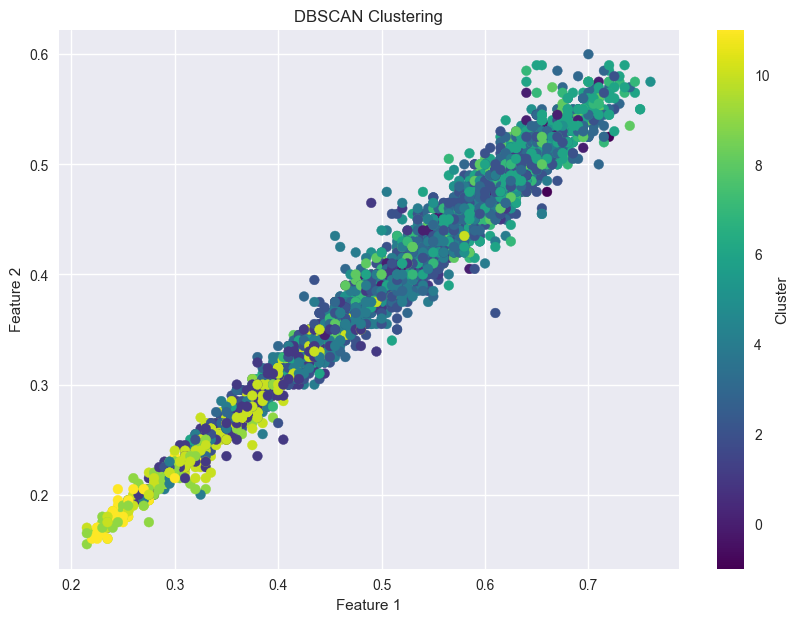

Number of clusters: 12
Number of noise points: 5

      length  diameter  height  whole_weight  shucked_weight  viscera_weight  shell_weight  rings  cluster  sex_encoded
0      0.455     0.365   0.095        0.5140          0.2245          0.1010        0.1500     15        0            2
1      0.350     0.265   0.090        0.2255          0.0995          0.0485        0.0700      7        1            2
2      0.530     0.420   0.135        0.6770          0.2565          0.1415        0.2100      9        2            0
3      0.440     0.365   0.125        0.5160          0.2155          0.1140        0.1550     10        3            2
4      0.330     0.255   0.080        0.2050          0.0895          0.0395        0.0550      7        1            1
...      ...       ...     ...           ...             ...             ...           ...    ...      ...          ...
3757   0.565     0.450   0.165        0.8870          0.3700          0.2390        0.2490     11        6    

In [124]:
# Basic DBSCAN Example
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

X_clus = df.drop(columns=['sex_encoded'], axis=1)

# Additional info about your data
print(f"Total data points: {len(X_clus)}")
print(f"Features used: {list(X_clus.columns)}")
print(f"Data shape: {X_clus.shape}") 

# Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=10)
clusters = dbscan.fit_predict(X_clus)

# Plot results
plt.figure(figsize=(10, 7))
plt.scatter(X_clus.iloc[:, 0], X_clus.iloc[:, 1], c=clusters, cmap='viridis', marker='o')
#plt.scatter(X_clus['sex_encoded'], X_clus['diameter'], c=clusters, cmap='viridis', marker='o')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

# Option 2: If you want to plot specific features by name (replace with actual column names)
# plt.scatter(X_clus['sex_encoded'], X_clus['feature_name_2'], c=clusters, cmap='viridis', marker='o')
# plt.xlabel('Feature Name 1')
# plt.ylabel('Feature Name 2') 

# Print cluster info
print(f"Number of clusters: {len(set(clusters)) - (1 if -1 in clusters else 0)}")
print(f"Number of noise points: {list(clusters).count(-1)}\n")

# Add cluster labels to dataframe
df['cluster'] = clusters

print(df)
print(f"Cluster summary:\n")
print(df.groupby('cluster').mean())